In [236]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [237]:
# Remove pandas duplication of the first column within the file
df = pd.read_csv('./churn_clean.csv', index_col=0)

In [238]:
# View data types and column information, dataframe as a whole
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income             

In [239]:
# Check for duplicates
duplicates = df.duplicated(keep=False)
duplicate_rows = df[duplicates]
print(df.duplicated().value_counts())

False    10000
dtype: int64


In [240]:
# Clean up and prepare the data
# Rename the Outage column for proper spacing and easier understanding
df = df.rename(columns={'Outage_sec_perweek': 'Outages'})

# Rename the Onlinesecurity column for proper spacing
df = df.rename(columns={'OnlineSecurity': 'Online_Security'})

# Rename the Internetservice column for easier understanding
df = df.rename(columns={'InternetService': 'Internet'});

# Rename the Onlinebackup column for proper spacing
df = df.rename(columns={'OnlineBackup': 'Online_Backup'})

# Rename the Deviceprotection column for proper spacing
df = df.rename(columns={'DeviceProtection': 'Device_Protection'})

# Rename the Port_modem column for easier understanding
df = df.rename(columns={'Port_modem': 'Modem'})

# Rename the Techsupport column for proper spacing
df = df.rename(columns={'TechSupport': 'Tech_Support'})

# Rename the Streamingtv column for proper spacing
df = df.rename(columns={'StreamingTV': 'Streaming_TV'})

# Rename the Streamingmovies column for proper spacing
df = df.rename(columns={'StreamingMovies': 'Streaming_Movies'})

# Rename the Paperlessbilling column for proper spacing
df = df.rename(columns={'PaperlessBilling': 'Paperless_Billing'})

# Rename the Paymentmethod column for proper spacing
df = df.rename(columns={'PaymentMethod': 'Payment_Method'})

# Rename the Monthlycharge column for proper spacing
df = df.rename(columns={'MonthlyCharge': 'Monthly_Charge'})

# Rename the Yearly_equip_failure column for easier understanding
df = df.rename(columns={'Yearly_equip_failure': 'Equipment_Failures'})

# Rename the Bandwidth_GB_Year column for proper spacing and easier understanding
df = df.rename(columns={'Bandwidth_GB_Year': 'Bandwidth_Usage'})

# Rename items in 'Internet' to better understand dummy variables in later analysis
df['Internet'] = df['Internet'].replace({'Fiber Optic': 'Optic', 'DSL': 'DSL' , 'None' : 'None'})

# Rename items in 'Contract' to better understand dummy variables in later analysis
df['Contract'] = df['Contract'].replace({'Month-to-month': 'Month', 'Two Year': 'Two' , 'One year' : 'One'})

# Rename items in 'Marital' to better understand dummy variables in later analysis
df['Marital'] = df['Marital'].replace({'Divorced': 'Divorced', 'Widowed': 'Widowed' , 
                                       'Separated' : 'Separated' , 'Never Married' : 'Never' , 'Married' : 'Married'})

# Minimalize decimal places in applicable columns to limit data points for better understanding of the data
df["Age"] = df.Age.round(2)
df["Outages"] = df.Outages.round(2)
df["Equipment_Failures"] = df.Equipment_Failures.round(2)
df["Monthly_Charge"] = df.Monthly_Charge.round(2)
df["Bandwidth_Usage"] = df.Bandwidth_Usage.round(2)

In [241]:
# Fix minimum zip codes by converting column to string from int64, then front-fill with zeros to fill
df['Zip'] = df['Zip'].astype("str").str.zfill(5)

# Convert Area column to category from object
df["Area"] = df["Area"].astype("category")

# Convert Marital column to category from object
df["Marital"] = df["Marital"].astype("category")

# Convert Gender column to category from object
df["Gender"] = df["Gender"].astype("category")

# Convert Internet column to category from object
df["Internet"] = df["Internet"].astype("category")

# Convert Contract column to category from object
df["Contract"] = df["Contract"].astype("category")

# Convert Techie column to category from object
df["Techie"] = df["Techie"].astype("category")

# Convert Modem column to category from object
df["Modem"] = df["Modem"].astype("category")

# Convert Tablet column to category from object
df["Tablet"] = df["Tablet"].astype("category")

# Convert Streaming_TV column to category from object
df["Streaming_TV"] = df["Streaming_TV"].astype("category")

# Convert Streaming_Movies column to category from object
df["Streaming_Movies"] = df["Streaming_Movies"].astype("category")

# Convert Payment Method column to category from object
df["Payment_Method"] = df["Payment_Method"].astype("category")

# Convert Paperless_Billing column to category from object
df["Paperless_Billing"] = df["Paperless_Billing"].astype("category")

# Convert Churn column to category from object
df["Churn"] = df["Churn"].astype("category")

# Convert numeric values to int
df["Income"] = df["Income"].astype(int);
df["Children"] = df["Children"].astype(int);
df["Age"] = df["Age"].astype(int);
df["Tenure"] = df["Tenure"].astype(int);
df["Bandwidth_Usage"] = df["Bandwidth_Usage"].astype(int); 
df["Equipment_Failures"] = df["Equipment_Failures"].astype(int);
df["Outages"] = df["Outages"].astype(int);
df["Monthly_Charge"] = df["Monthly_Charge"].astype(int);
                                             
# Change all yes/no values to 1 or 0 by mapping
Cd_map = {'Yes': 1, 'No': 0};

# Apply the mapping to applicable columns
convert = ["Churn" , "Techie"  , "Tablet" , "Modem"]
df[convert] = df[convert].replace(Cd_map);

# Create dummy variables, keeping all data points
dummy_columns = ["Area" , "Gender" , "Marital", "Contract", "Internet" ]
df = pd.get_dummies(data=df, columns=dummy_columns, drop_first=False);

# Drop unnecessary columns from df
Cdrop = ["Customer_id", "Interaction", "UID", "City", "County", "Lat", "Lng", "Payment_Method" ,
                    "TimeZone", "Email", "Contacts", "Phone", "Paperless_Billing", 
                    "State", "Population", "Job" , "Phone" , "Multiple" , "Online_Security" , "Online_Backup" ,
                    "Device_Protection" , "Tech_Support" , "Streaming_TV" , "Streaming_Movies" , 
                    "Item1" , "Item2" , "Item3" , "Item4" , "Item5" , 
                    "Item6" , "Item7" , "Item8"]
df.drop(columns=Cdrop, axis=1, inplace=True)

# View resulting dataframe
df.head()

,Zip,Children,Age,Income,Churn,Outages,Equipment_Failures,Techie,Modem,Tablet,...,Marital_Married,Marital_Never,Marital_Separated,Marital_Widowed,Contract_Month,Contract_One,Contract_Two,Internet_DSL,Internet_None,Internet_Optic
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,99927,0,68,28561,0,7,1,0,1,1,...,0,0,0,1,0,1,0,0,0,1
2,48661,1,27,21704,1,11,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
3,97148,4,50,9609,0,10,1,1,1,0,...,0,0,0,1,0,0,1,1,0,0
4,92014,1,48,18925,0,14,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
5,77461,0,83,40074,1,8,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1


In [242]:
# Save the cleaned DataFrame to CSV
df.to_csv('Clean_df.csv', index=False)

In [243]:
# Begin anaylsis by separating the X variables (features) from the Y variable (target)
Xdf = df.drop(["Churn"], axis=1)
Ydf = df["Churn"]

In [244]:
# Print X variables to verify changes made in data transformation steps
Xdf

,Zip,Children,Age,Income,Outages,Equipment_Failures,Techie,Modem,Tablet,Tenure,...,Marital_Married,Marital_Never,Marital_Separated,Marital_Widowed,Contract_Month,Contract_One,Contract_Two,Internet_DSL,Internet_None,Internet_Optic
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,99927,0,68,28561,7,1,0,1,1,6,...,0,0,0,1,0,1,0,0,0,1
2,48661,1,27,21704,11,1,1,0,1,1,...,1,0,0,0,1,0,0,0,0,1
3,97148,4,50,9609,10,1,1,1,0,15,...,0,0,0,1,0,0,1,1,0,0
4,92014,1,48,18925,14,0,1,0,0,17,...,1,0,0,0,0,0,1,1,0,0
5,77461,0,83,40074,8,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,05758,3,23,55723,9,0,0,1,1,68,...,1,0,0,0,1,0,0,1,0,0
9997,37042,4,48,34129,6,0,0,0,0,61,...,0,0,0,0,0,0,1,0,0,1
9998,79061,1,48,45983,6,0,0,0,0,47,...,0,1,0,0,1,0,0,0,0,1


In [245]:
# View Y variables to verify changes made in data transformation steps
Ydf

CaseOrder
1        0
2        1
3        0
4        0
5        1
        ..
9996     0
9997     0
9998     0
9999     0
10000    0
Name: Churn, Length: 10000, dtype: category
Categories (2, int64): [0, 1]

In [246]:
# Identify X and y for train/test split
X = Xdf
y = Ydf
# Split the data into train and test sets, 70% train 30% test, maintain proportions by stratifying the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size=0.3, random_state = 42, stratify = y)

In [247]:
# Save each data set to CSV
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
X_train_df.to_csv('X_train.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

In [248]:
# Normalize/scale the features for KNN
s_X = StandardScaler()
X_train = s_X.fit_transform(X_train)
X_test = s_X.transform(X_test)

In [249]:
# Identify k values
k_values = list(range(1, 50))
scores = []

In [250]:
# Create KNN classifier with varying values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='euclidean')
# Compute cross-validation and mean score
score = np.mean(cross_val_score(knn, X_train, y_train, cv=5))
scores.append(score)
# Find the index of the best score for k value
best_index = np.argmax(scores)
best_k = k_values[best_index]

In [251]:
# Train final classifier 
final_knn = KNeighborsClassifier(n_neighbors=best_k, p=2, metric='euclidean')
final_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [252]:
# Make predictions using the final model
y_pred = final_knn.predict(X_test)

In [253]:
# Evaluate the model using accuracy, f1, confusion matrix and roc/auc
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cmat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_knn.predict_proba(X_test)[:, 1])
# Print scores
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cmat)
print("ROC AUC:", roc_auc)

Accuracy: 0.7733333333333333
F1 Score: 0.5663265306122448
Confusion Matrix:
 [[1876  329]
 [ 351  444]]
ROC AUC: 0.7046421084156932


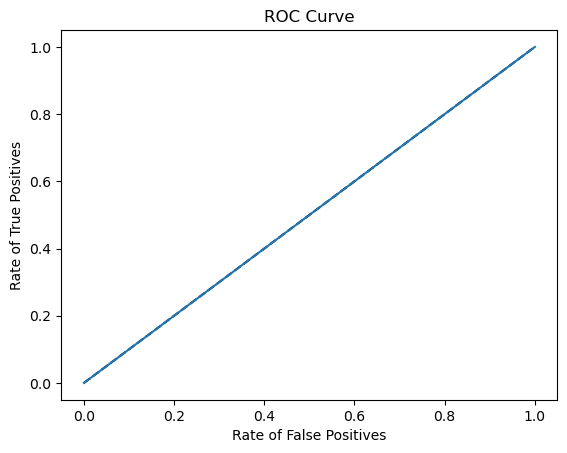

In [257]:
# Plot ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('Rate of False Positives')
plt.ylabel('Rate of True Positives')
plt.title('ROC Curve')
plt.show()

In [255]:
# Combine Xdf and Ydf into a new DataFrame named Cdf
Cdf = pd.concat([Xdf, Ydf.reset_index().drop('CaseOrder', axis=1)])

# Save the combined DataFrame to CSV
Cdf.to_csv('Cdf.csv', index=False)